In [1]:
!pip install --upgrade mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.1 MB/s eta 0:00:00


In [15]:
!pip install optuna
!pip install pmdarima

import datetime
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import yfinance as yf


import pandas_datareader as pdr
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
######################################################################################
stock_data = yf.download('AAPL') # you can choose whatever stockticker you want

num_days_pred=30 # Number of days you want to predict in the future the higher the less accuracy
######################################################################################

# Here I choose to only use the last 3 years of stock data
slice = int(len(stock_data)- 356*3)
stock_data = stock_data.iloc[slice:]

# Here I Choose to continue with only Close value column since that is what we care about
stock_data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)


# Function to calculate mean absolute error percentage
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def add_lags(df,num_days_pred=num_days_pred):
    target = 'Close'
    df['lag1'] = df[target].shift(num_days_pred)
    df['lag2'] = df[target].shift(num_days_pred*2)
    df['lag3'] = df[target].shift(num_days_pred*3)
    df['lag4'] = df[target].shift(num_days_pred*4)
    df['lag5'] = df[target].shift(num_days_pred*5)
    df['lag6'] = df[target].shift(num_days_pred*6)
    df['lag7'] = df[target].shift(num_days_pred*7)
    df['lag8'] = df[target].shift(num_days_pred*8)
    df['lag9'] = df[target].shift(num_days_pred*9)
    df['lag10'] = df[target].shift(num_days_pred*10)
    df['lag11'] = df[target].shift(num_days_pred*11)
    df['lag12'] = df[target].shift(num_days_pred*12)



    return df

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.7 MB/s eta 0:00:00


[*********************100%%**********************]  1 of 1 completed


In [16]:
df_xgb = stock_data.copy()

In [17]:
def xgboostmodel(df_xgb,add_lags,create_features,num_days_pred=num_days_pred):

    df_xgb = create_features(df_xgb)
    df_xgb = add_lags(df_xgb)

    X = df_xgb.drop(columns='Close')
    y = df_xgb['Close']
    return X,y
X,y = xgboostmodel(df_xgb ,add_lags,create_features,num_days_pred=30)

In [18]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
        #'tree_method': 'gpu_hist',
    }

    # Initialize XGBoost regressor with the suggested parameters
    xgb = XGBRegressor(**param)

    # Fit the model on training data
    xgb.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = xgb.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = xgb_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

[I 2024-04-21 17:55:07,885] A new study created in memory with name: no-name-917488c8-1162-40ea-9da5-2180ebb89c35
[I 2024-04-21 17:55:14,908] Trial 0 finished with value: 3.2900638832444935 and parameters: {'n_estimators': 778, 'max_depth': 8, 'learning_rate': 0.017404949786548135, 'subsample': 0.9844181837923907, 'colsample_bytree': 0.7646107895082739, 'reg_alpha': 3.049412323522737, 'reg_lambda': 2.0540240501655704}. Best is trial 0 with value: 3.2900638832444935.
[I 2024-04-21 17:55:15,831] Trial 1 finished with value: 3.6456524990143695 and parameters: {'n_estimators': 960, 'max_depth': 3, 'learning_rate': 0.04733488156625395, 'subsample': 0.9313877085324813, 'colsample_bytree': 0.6696398488684738, 'reg_alpha': 0.5956078080850757, 'reg_lambda': 4.067431923481928}. Best is trial 0 with value: 3.2900638832444935.
[I 2024-04-21 17:55:23,541] Trial 2 finished with value: 3.512099526482112 and parameters: {'n_estimators': 335, 'max_depth': 9, 'learning_rate': 0.05037631372331203, 'subsa

Best trial:
  Value: 3.0164675544240698
  Params: 
    n_estimators: 865
    max_depth: 10
    learning_rate: 0.08801558184820915
    subsample: 0.8178909940296167
    colsample_bytree: 0.6205949020909126
    reg_alpha: 8.064123974185929
    reg_lambda: 2.662981485825013
Test RMSE: 3.0164675544240698


In [19]:
y_pred_test_xgb = xgb_best.predict(X_test)
xgb_loss = mean_absolute_percentage_error(y_test, y_pred_test_xgb)
print(f"ERROR PERCENT = { mean_absolute_percentage_error(y_test, y_pred_test_xgb) }% ")

ERROR PERCENT = 1.6699474898012208% 


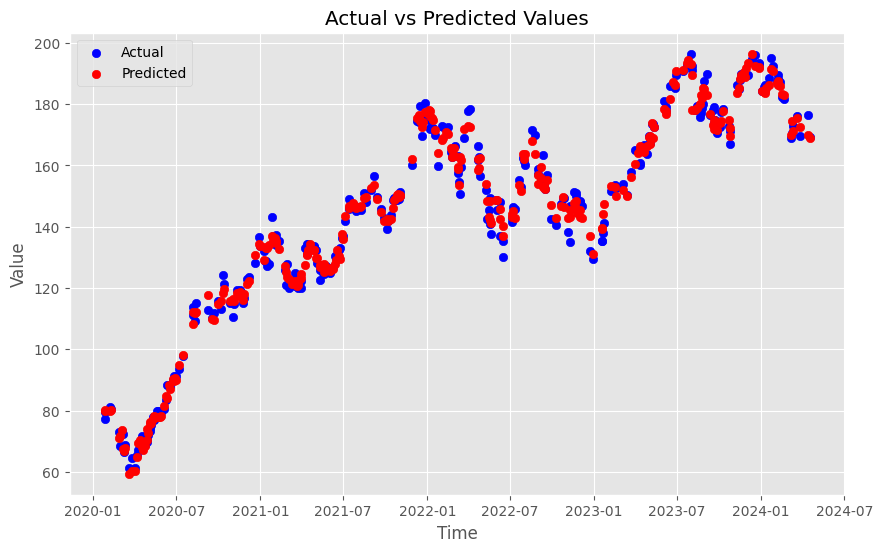

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test_xgb , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

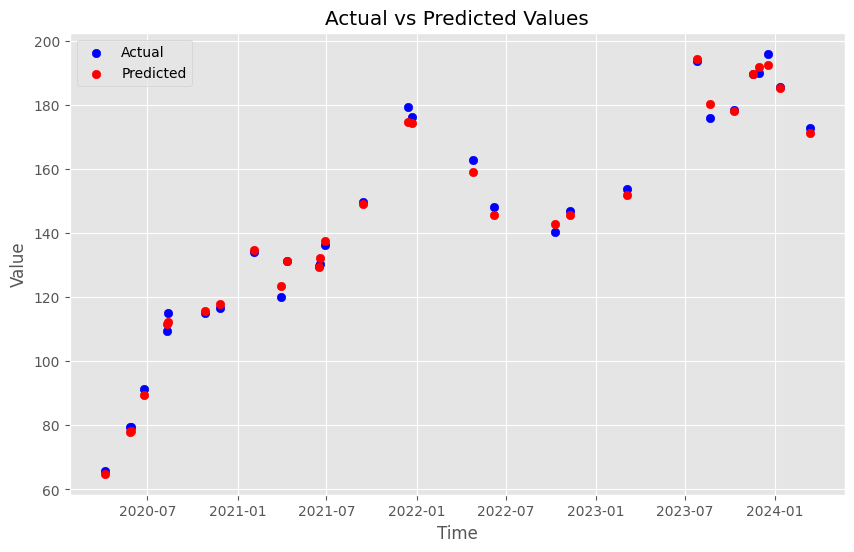

In [21]:
# Let's ZoomIn
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test_xgb[:30] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

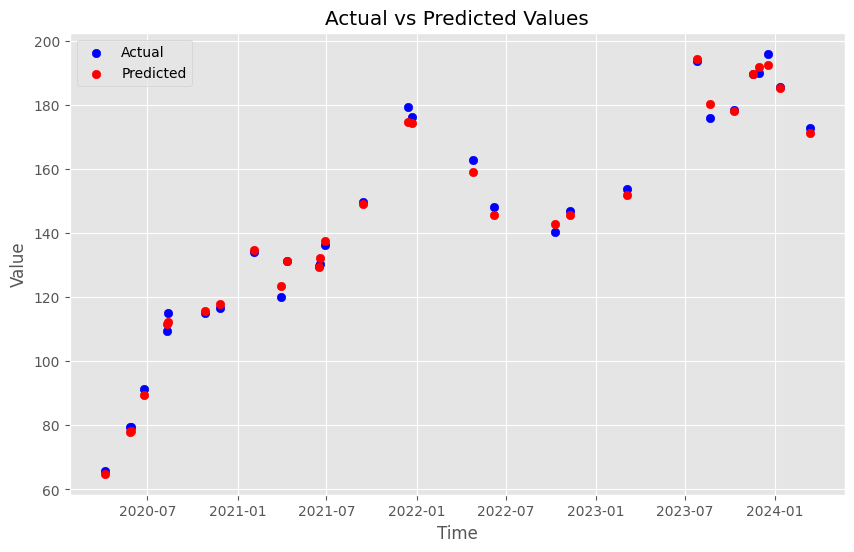

In [22]:
# Let's ZoomIn
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test_xgb[:30] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

Predict In The Future

In [23]:
start = df_xgb.index.max()
end = start + pd.Timedelta(days=num_days_pred)


In [24]:
future = pd.date_range(start=start,end=end,freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture']= True
df_xgb['isFuture']= False
df_and_future = pd.concat([df_xgb,future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()

In [25]:
future_w_features['pred'] = xgb_best.predict(future_w_features.drop(columns=['Close','isFuture']))


In [26]:
prediction_xgb = pd.DataFrame(future_w_features['pred'])
prediction_xgb

,pred
2024-04-19,163.188065
2024-04-20,170.534637
2024-04-21,170.809616
2024-04-22,169.194244
2024-04-23,172.836868
2024-04-24,171.774353
2024-04-25,168.551712
2024-04-26,172.058533
2024-04-27,172.216370
2024-04-28,168.659790


Prophet

In [27]:
df_prophet = stock_data.copy()

SPLIT

In [28]:
split_date = df_prophet.index[int(len(df_prophet) * 0.8)]
train = df_prophet.loc[df_prophet.index <= split_date].copy()
test = df_prophet.loc[df_prophet.index > split_date].copy()

DATA preprocessing

In [29]:
# Format data for prophet model using ds and y
train_prophet = train.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})

In [30]:
train_prophet

,ds,y
0,2020-01-23,79.807503
1,2020-01-24,79.577499
2,2020-01-27,77.237503
3,2020-01-28,79.422501
4,2020-01-29,81.084999
...,...,...
850,2023-06-08,180.570007
851,2023-06-09,180.960007
852,2023-06-12,183.789993
853,2023-06-13,183.309998


Training of datset

In [31]:
prophet = Prophet()
prophet.fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplbjqbjdm/y4hr72ra.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplbjqbjdm/ipbr1fed.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51496', 'data', 'file=/tmp/tmplbjqbjdm/y4hr72ra.json', 'init=/tmp/tmplbjqbjdm/ipbr1fed.json', 'output', 'file=/tmp/tmplbjqbjdm/prophet_model0t4hyhk8/prophet_model-20240421180058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [32]:
# Format data for prophet model using ds and y
test_prophet = test.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})
test_predict = prophet.predict(test_prophet)

Evaluating

In [33]:
porphet_loss = mean_absolute_percentage_error(test['Close'],test_predict['yhat'] )
print(f"ERROR PERCENT = { mean_absolute_percentage_error(test['Close'],test_predict['yhat'] ) }% ")

ERROR PERCENT = 14.104572223950363% 


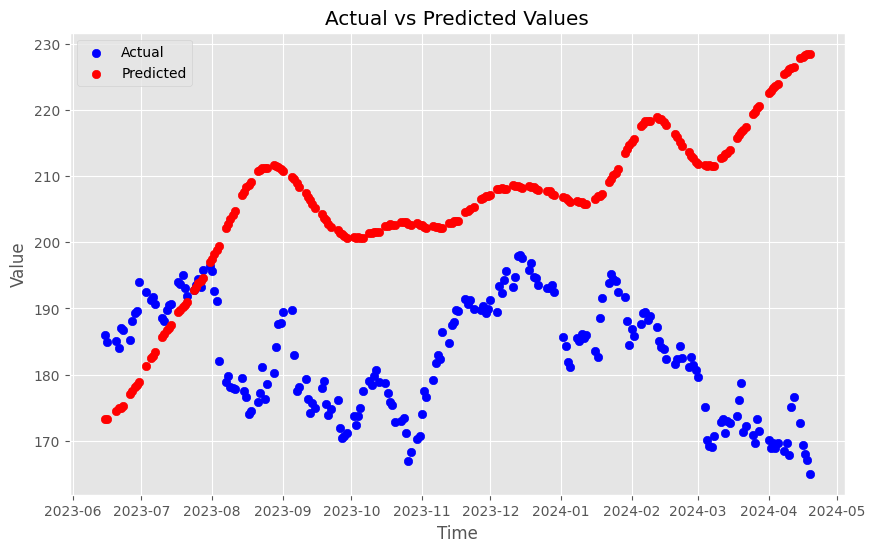

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(test.index, test['Close'], color='blue', label='Actual')
plt.scatter(test.index, test_predict['yhat'] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

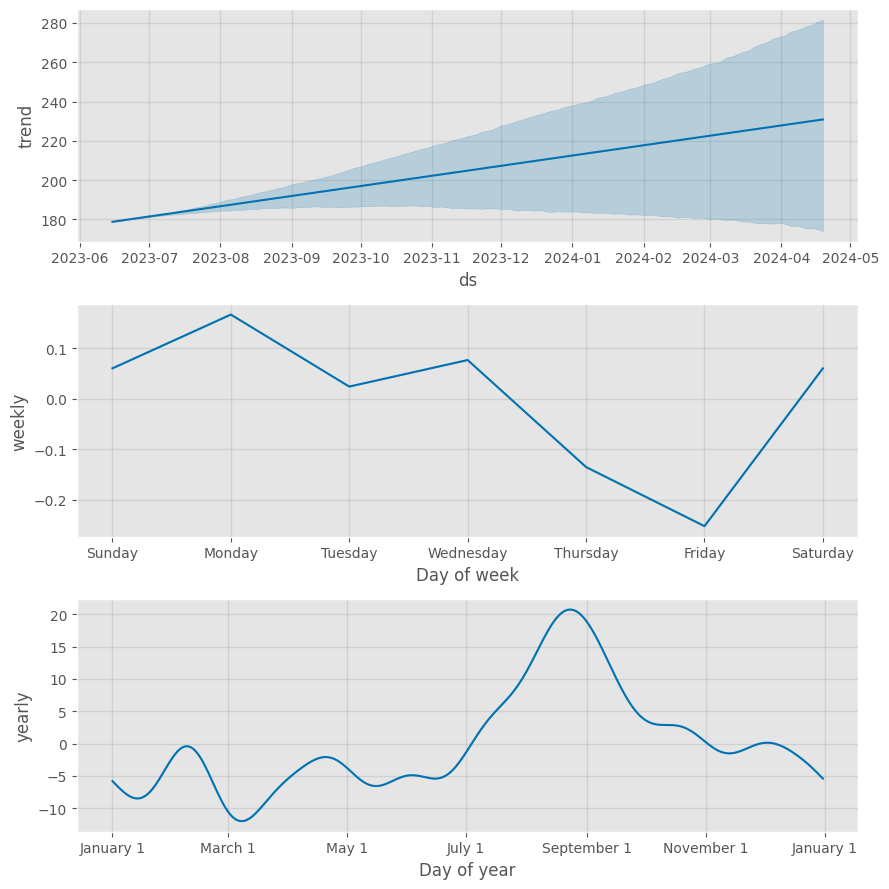

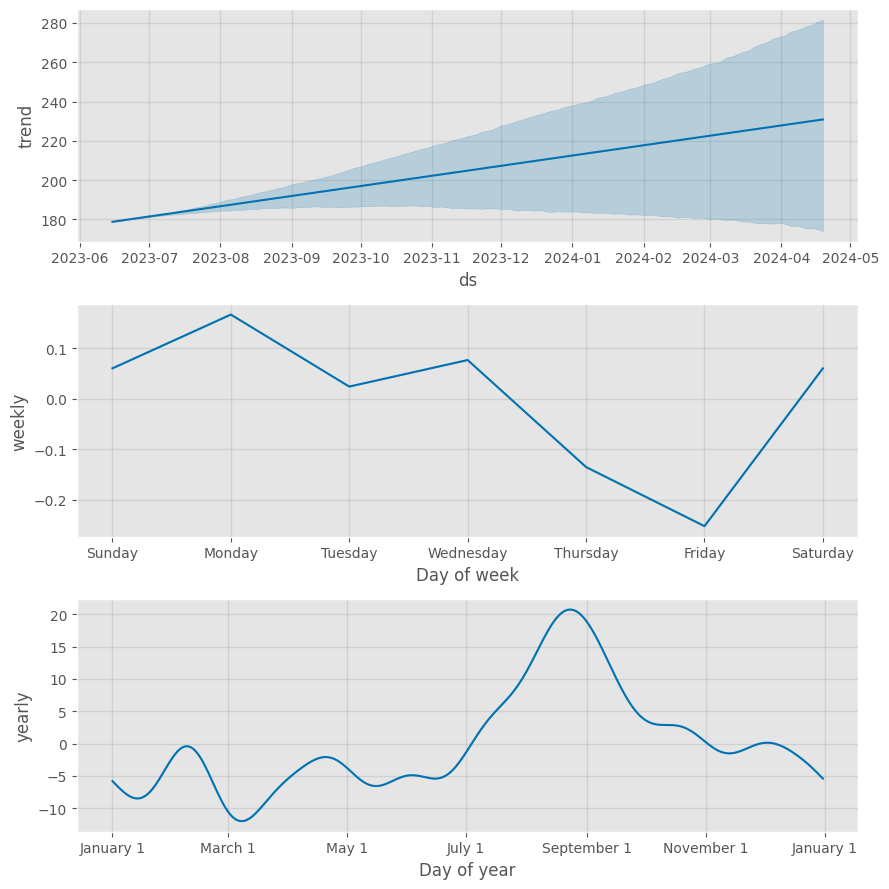

In [35]:
prophet.plot_components(test_predict)

Predicting in the Future

In [36]:
prophet_data = df_prophet.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})
prophet = Prophet()
prophet.fit(prophet_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplbjqbjdm/3ptfo8z2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplbjqbjdm/x2epda7p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99088', 'data', 'file=/tmp/tmplbjqbjdm/3ptfo8z2.json', 'init=/tmp/tmplbjqbjdm/x2epda7p.json', 'output', 'file=/tmp/tmplbjqbjdm/prophet_model8t_36u5k/prophet_model-20240421180231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [37]:
future = prophet.make_future_dataframe(periods=num_days_pred, freq='d', include_history=False)
forecast = prophet.predict(future)
forecast_prophet = forecast[['ds','yhat']]
forecast_prophet.index = forecast_prophet.pop('ds')

In [38]:
forecast_prophet

,yhat
ds,
2024-04-20,181.840570
2024-04-21,181.664710
2024-04-22,172.221966
2024-04-23,171.904619
2024-04-24,171.718307
2024-04-25,171.362816
2024-04-26,171.071442
2024-04-27,180.310629
2024-04-28,180.042700


ARIMA

In [39]:
df_arima = stock_data.copy()

In [40]:
split_date = df_prophet.index[int(len(df_arima) * 0.8)]
train_arima = df_arima.loc[df_arima.index <= split_date].copy()
test_arima = df_arima.loc[df_arima.index > split_date].copy()

In [41]:
# Try to find the best parameters for arima model
stepwise_fit = auto_arima(train_arima['Close'],trace=True,suppress_warnings=True)
# assign the parameter to "best_order" variable
best_order = stepwise_fit.get_params()['order']


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4149.433, Time=1.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4145.990, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4145.232, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4145.041, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4145.687, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4145.853, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4146.130, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4147.794, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4144.964, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4145.994, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4146.192, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4145.128, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4147.937, Time=0.19 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.959 seconds


In [42]:
arima = ARIMA(train_arima['Close'], order=best_order)
arima = arima.fit()

In [43]:
start = len(train_arima)
end = len(test_arima) + len(train_arima)

<Axes: xlabel='Date'>

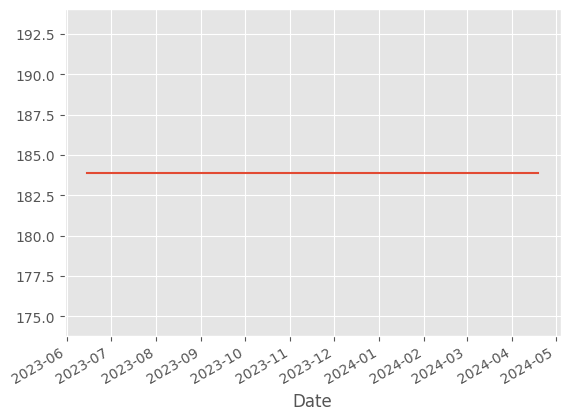

In [44]:
pred_arima = arima.predict(start=start,end=end-1)
pred_arima.index = test_arima.index
pred_arima.plot()

In [45]:
arima_loss = mean_absolute_percentage_error(test_arima['Close'],pred_arima )
print(f"ERROR PERCENT = { mean_absolute_percentage_error(test_arima['Close'],pred_arima ) }% ")

ERROR PERCENT = 4.168362640386239% 


In [46]:
# Try to find the best parameters for arima model
stepwise_fit = auto_arima(df_arima['Close'],trace=True,suppress_warnings=True)
# assign the parameter to "best_order" variable
best_order = stepwise_fit.get_params()['order']

arima = ARIMA(df_arima['Close'], order=best_order)
arima = arima.fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5105.044, Time=6.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5110.191, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5111.228, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5111.187, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5109.161, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5114.500, Time=1.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5114.500, Time=0.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5114.676, Time=2.67 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5114.801, Time=2.87 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5112.521, Time=0.52 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5112.481, Time=0.80 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5116.453, Time=1.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5117.760, Time=10.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5098.706, Time=3.67 sec
 ARIMA(1,1,2)(0,0,0)[0]         

In [47]:
start = len(df_arima)
end = len(df_arima) + num_days_pred
arima_forecast = arima.predict(start=start,end=end)

In [48]:
start = df_arima.index.max()
end = start + pd.Timedelta(days=num_days_pred)
arima_forecast.index = pd.date_range(start, end, freq='1d')

In [49]:
arima_forecast = pd.DataFrame(arima_forecast)

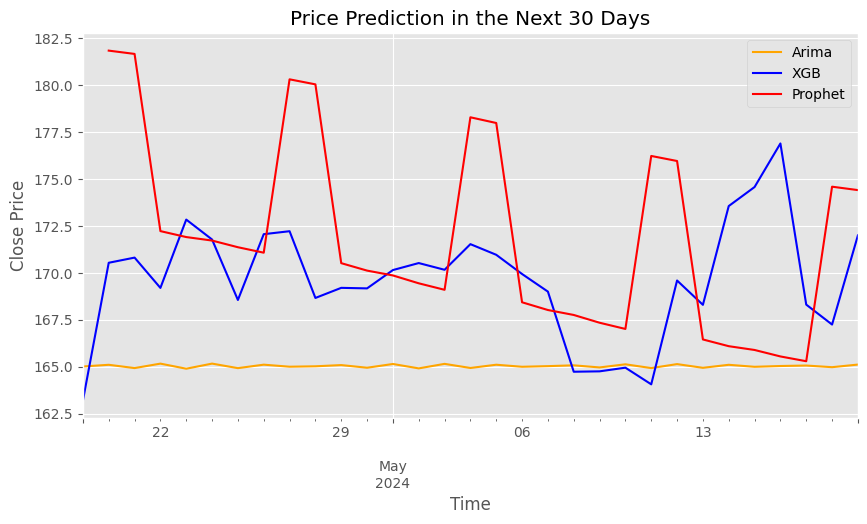

In [50]:
fig, ax  = plt.subplots(figsize=(10,5))
arima_forecast.plot(color='orange',ax=ax)
prediction_xgb.plot(color = 'blue',ax=ax)
forecast_prophet.plot(color = 'red',ax=ax)
plt.legend(['Arima','XGB','Prophet'])
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(f"Price Prediction in the Next {num_days_pred} Days");

In [51]:
print(f"XGB Acc : {100-xgb_loss} \nArima Acc : {100-arima_loss}\nProphet Acc : {100- porphet_loss}")

XGB Acc : 98.33005251019878 
Arima Acc : 95.83163735961377
Prophet Acc : 85.89542777604964
